## Ejemplo de una solución numérica

En este notebook vamos a resolver las ecuaciones de momento linealizadas para un dominio rectangular. Esto quiere decir que econtraremos la altura de la superficie libre del mar, $h=h(x,y,t)$, y las componentes horizontales de velocidad $\vec{u}(x,y,t)=(u,v)$ a un tiempo dado integrando
numéricamente el siguiente sistema de ecuaciones:

$$\frac{\partial{u}}{\partial{t}}=g\frac{\partial{h}}{\partial{x}}$$
$$\frac{\partial{v}}{\partial{t}}=g\frac{\partial{h}}{\partial{y}}$$
$$\frac{\partial{h}}{\partial{t}}+H\left(\frac{\partial{u}}{\partial{x}}+\frac{\partial{v}}{\partial{y}}\right)=0,$$

en donde $H$ es la profundidad de la capa sin perturbar y $g$ la aceleración de la gravedad.

<img src='SW.png'>

Además, practicaremos la separación de código en funciones para generar nuestro primer modelo numérico.

In [1]:
# Importamos las bibliotecas y paquetes de python que usaremos para correr este notebook

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Definición de constantes
g = 9.81         # gravedad en m/s2
rho = 1025       # densidad del agua de mar en km/m3
X = 200          # 
Y = 300
Xvec = np.arange(0,X,1)
Yvec = np.arange(0,Y,1)

# Batimetría
H = np.ones((X,Y))*1000 # Arreglo de dimensiones (X,Y) lleno del valor 1000

# Inicialización de las variables
h = H*0               # Anomalía de la profundidad
h0 = h                # Anomalía de la profundidad en tiempo t=0
h2 = h                # Anomalía de la profundidad en tiempo t=2
u0 = np.zeros((X+1,Y))  # Velocidad inicial (en tiempo t=0)
u2 = u0               # Velocidad en tiempo t=2
v0 = np.zeros((X,Y+1))  # Velocidad en tiempo t=0
v2 = v0               # Velocidad en tiempo t=2

DelX = 100 # Resolución espacial , un kilómetro
DelT = 0.5 # Paso de tiempo en segundos
CFL = np.sqrt(g*np.max(H))*DelT/DelX # Condición de estabilidad Courant-Friederich-Levy

Una vez que definimos el dominio espacial en donde resolveremos las ecuaciones, generemos una perturbación en la superficie libre de la forma

$$h(x,y)= B \exp\left(-\frac{x^2}{2\sigma_x^2}-\frac{y^2}{2\sigma_y^2}\right),$$

donde B nos dará la altura inicial de la perturbación y $\sigma_x$, $\sigma_y$ la desviación estándar o el "ancho" de la gausiana en las direcciones $x$ y $y$, respectivamente.

(300, 200) (300, 200)
1.0


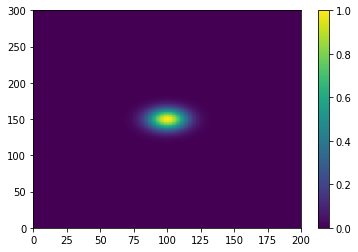

In [3]:
# Perturbación inicial de la superficie (un tope gaussiano)

z = np.zeros((X,Y))
x,y = np.meshgrid(Xvec,Yvec)
print(np.shape(x), np.shape(y))

sigma_x = 0.2*X/4
sigma_y = 0.2*X/4
B = 1 # Altura inicial de la perturbación
z = B * np.exp(-((x-100)**2/(2*sigma_x**2) + (y-150)**2/(2*sigma_y**2)))
print(np.max(z))

# Gráfica rápida
plt.pcolormesh(z)
plt.colorbar()
plt.show()

O podemos hacer una gráfica más ilustrativa de la perturbación inicial. Para eso necesitaremos importar la biblioteca `mplot3d`:

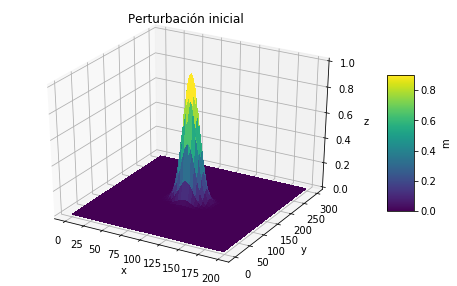

In [4]:
from mpl_toolkits import mplot3d

fig = plt.figure(figsize=(8,5))
ax = plt.axes(projection='3d')

surf = ax.plot_surface(x, y, z,cmap='viridis', edgecolor='none',antialiased=False)
ax.set_title('Perturbación inicial')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

fig.colorbar(surf, shrink=0.5, aspect=5, label='m')

plt.show()

Ahora sí, resolvamos el sistema de ecuaciones con condiciones iniciales y de frontera...

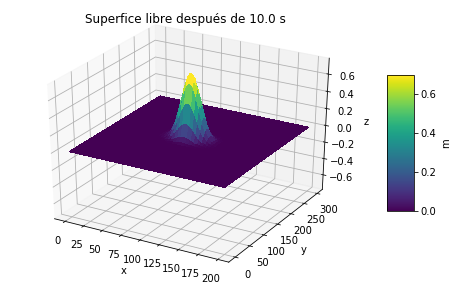

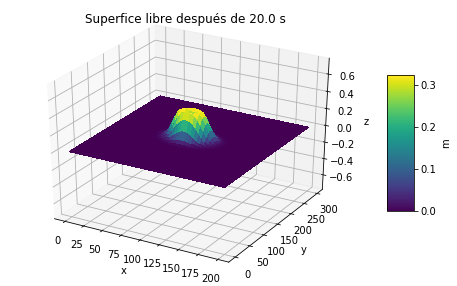

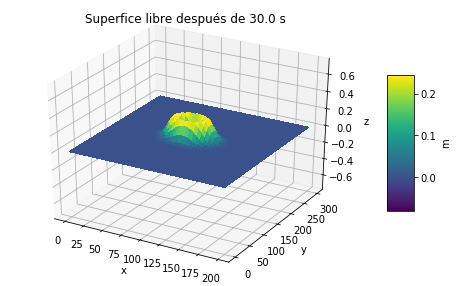

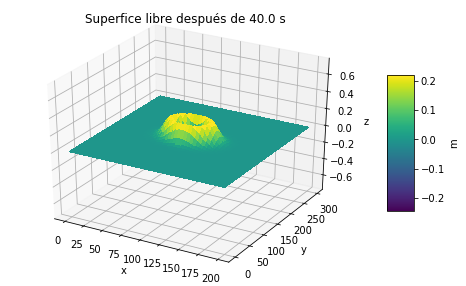

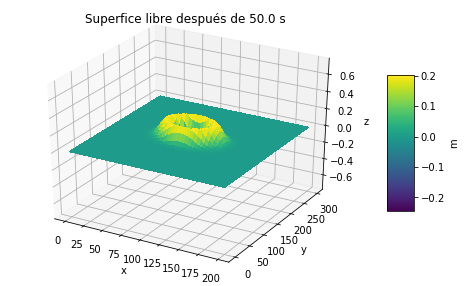

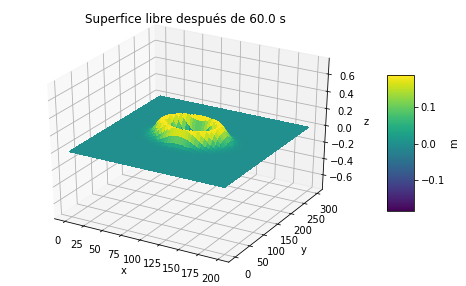

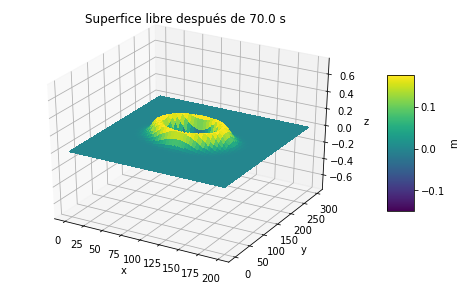

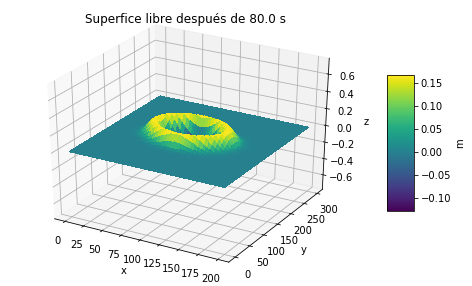

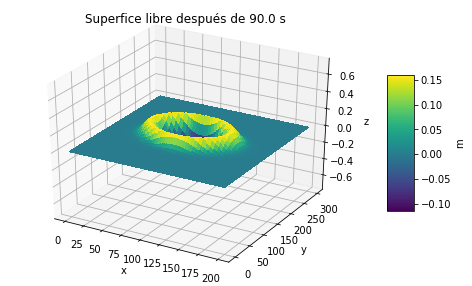

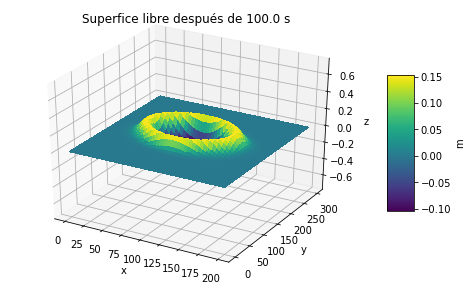

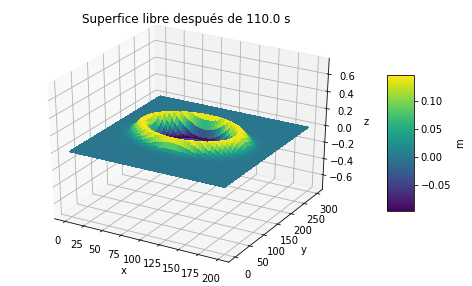

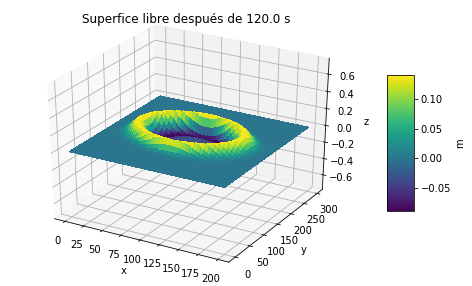

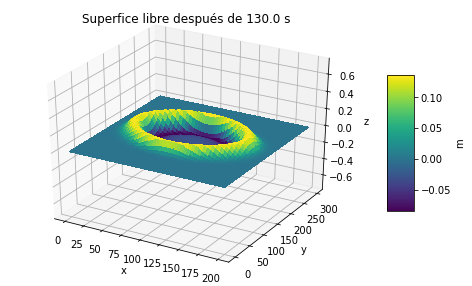

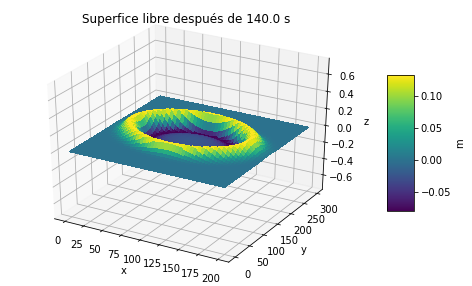

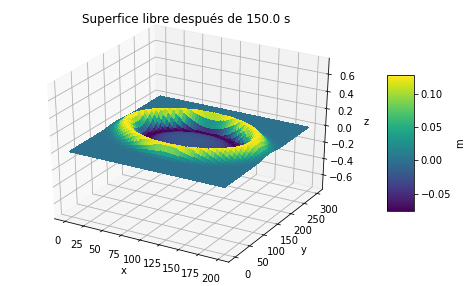

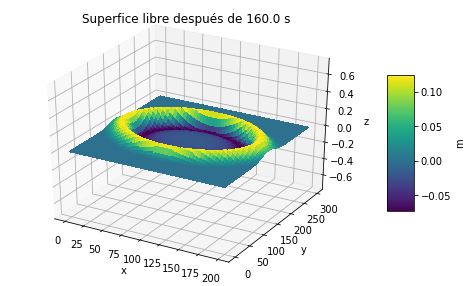

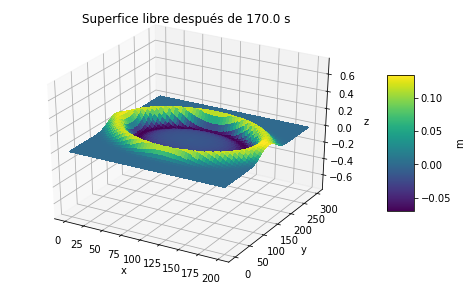

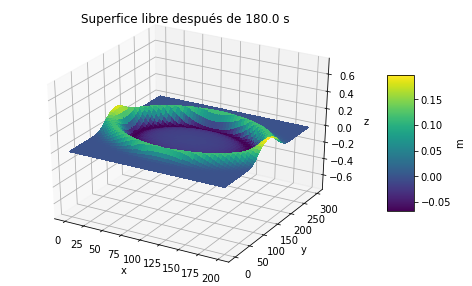

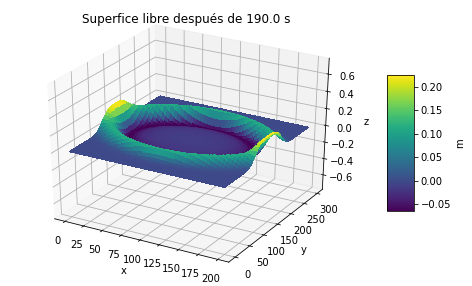

In [5]:
# timestepping
nt = 200 
for t in range(1,nt):
    if t==1:
        h0 = np.transpose(z)
    
    # Velocidad 0 en las fronteras     
    u0[-1,:] = 0
    u0[0,:] = 0
    v0[:,0] = 0
    v0[:,-1] = 0
    
    u2[1:X,0:Y] = u0[1:X,0:Y] - g*(h0[1:X,0:Y] - h0[0:X-1,0:Y]) * DelT/DelX
    
    v2[0:X,1:Y] = v0[0:X,1:Y] - g*(h0[0:X,1:Y] - h0[0:X,0:Y-1]) * DelT/DelX
    
    h2[0:X,0:Y] = (h0[0:X,0:Y] - H[0:X,0:Y]*
                   (u2[1:X+1,0:Y] - u2[0:X,0:Y] + 
                    v2[0:X,1:Y+1] - v2[0:X,0:Y])* DelT/DelX)
    
    u0 = u2
    v0 = v2
    h0 = h2
    
    if t%10 == 0:
        fig = plt.figure(figsize=(8,5))
        ax = plt.axes(projection='3d')
        surf = ax.plot_surface(x, y, np.transpose(h2), cmap='viridis', 
                               edgecolor='none',antialiased=False)
        ax.set_title('Superfice libre después de %1.1f s' %t)
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('z')
        ax.set_zlim(-0.75,0.75)
        fig.colorbar(surf, shrink=0.5, aspect=5, label='m')
        plt.show()

### Hagamos un pequeño modelo

Ahora que hemos desarrollado código para resolver este sistema de ecuaciones sería práctico agruparlo en unidades de código que hacen una sola tarea, es decir, en funciones. Así podremos correr nuestro modelo con distintos parámetros sin tener que copiar y pegar todo el código que escibimos arriba.
 
Para ello definiremos 5 funciones:

**inicia** será la función que inicialice las variables del modelo;

**perturba** generará las condiciones inciales en la superfice libre; 

**adelanta** será la función que integra las ecuaciones discretizadas en el tiempo,

**grafica** generará la gráfica de la superficie libre y

**corre** será la función maestra que llama a las demás funciones ("wrapper").

In [6]:
def inicializa(X,Y,g,Hmax,DelT,DelX,rho):
    '''Esta función inicializa la malla, variables dinámicas y constantes para usar en el modelo.
    OUTPUT
    X, Y, x, y, g, Hmax, DelT, DelX, rho
    '''
    Xvec = np.arange(0,X,1)
    Yvec = np.arange(0,Y,1)
    x,y = np.meshgrid(Xvec,Yvec)

    # Batimetría
    H = np.ones((X,Y))*Hmax # Arreglo de dimensiones (X,Y) lleno del valor 1000

    # Inicialización de las variables dinámicas
    h = H*0                 # Anomalía de la profundidad
    h0 = h                  # Anomalía de la profundidad en tiempo t=0
    h2 = h                  # Anomalía de la profundidad en tiempo t=2
    u0 = np.zeros((X+1,Y))  # Velocidad inicial (en tiempo t=0)
    u2 = u0                 # Velocidad en tiempo t=2
    v0 = np.zeros((X,Y+1))  # Velocidad en tiempo t=0
    v2 = v0                 # Velocidad en tiempo t=2

    CFL = np.sqrt(g*np.max(H))*DelT/DelX # Condición de estabilidad Courant-Friederich-Levy
    print('la malla es de dimensiones:')
    print(np.shape(x))
    print('El paso de tiempo es %1.2f' %DelT)
    print('La resolución espacial es %1.2f' %DelX)
    print('El valor de CFL es %f' %CFL)
    
    return(X, Y, x, y, h0, h2, u0, u2, v0, v2, H, g, Hmax, DelT, DelX, rho)

def perturba(x, y, X, Y, B, s_x, s_y):
    '''Esta función genera una perturbación inicial gausiana en la superficie libre.
    INPUT
    x, y :: arreglos numpy 2D de dim (X,Y), la malla
    B :: real, Altura inicial de la perturbación
    s_x :: factor para calcular la desviación estándar de la gausiana en dirección x 
           como s_x*X/4
    s_y :: factor para calcular la desviación estándar de la gausiana en dirección x 
           como s_y*X/4
    OUTPUT
    z :: arreglo numpy 2D dim (X,Y) con la gausiana.
    '''
    sigma_x = s_x*X/4
    sigma_y = s_y*X/4
    z = B * np.exp(-((x-int(X/2))**2/(2*sigma_x**2) + (y-int(Y/2))**2/(2*sigma_y**2)))
    
    return(z)

def adelanta(u0, u2, v0, v2, h0, h2, H, g, delT, delX):
    '''Esta función evoluciona las componentes de velocidad (u0, v0, u2, v2)
    y la superficie libre (h0, h2) en un paso de tiempo de tamaño delT, para 
    una malla regular de resolución delX. 
    
    INPUT
    u0 :: arreglo numpy 2D, componente x de la velocidad en nt-1, dim(X+1,Y)
    u2 :: arreglo numpy 2D, componente x de la velocidad en nt+1, dim(X+1,Y)
    v0 :: arreglo numpy 2D, componente y de la velocidad en nt-1, dim(X,Y+1)
    v2 :: arreglo numpy 2D, componente y de la velocidad en nt+1, dim(X,Y+1)
    h0 :: arreglo numpy 2D, superificie libre en nt-1, dim(X,Y)
    h2 :: arreglo numpy 2D, superificie libre en nt+1, dim(X,Y)
    H  :: arreglo numpy 2D, profundidad, dim(X,Y) 
    g  :: escalar, valor de la gravedad en m/s2
    delT :: escalar, paso de tiempo en segundos
    delX :: escalar, resolución espacial en kilometros
    
    OUTPUT
    u0 :: arreglo numpy 2D, componente x de la velocidad en nt-1, dim(X+1,Y)
    u2 :: arreglo numpy 2D, componente x de la velocidad en nt+1, dim(X+1,Y)
    v0 :: arreglo numpy 2D, componente y de la velocidad en nt-1, dim(X,Y+1)
    v2 :: arreglo numpy 2D, componente y de la velocidad en nt+1, dim(X,Y+1)
    h0 :: arreglo numpy 2D, superificie libre en nt-1, dim(X,Y)
    h2 :: arreglo numpy 2D, superificie libre en nt+1, dim(X,Y)
    '''
    # Condiciones de frontera
    u0[-1,:] = 0
    u0[0,:] = 0
    v0[:,0] = 0
    v0[:,-1] = 0
    
    # Evolución temporal
    u2[1:X,0:Y] = u0[1:X,0:Y] - g*(h0[1:X,0:Y] - h0[0:X-1,0:Y]) * DelT/DelX
    v2[0:X,1:Y] = v0[0:X,1:Y] - g*(h0[0:X,1:Y] - h0[0:X,0:Y-1]) * DelT/DelX
    h2[0:X,0:Y] = (h0[0:X,0:Y] - H[0:X,0:Y]*
                   (u2[1:X+1,0:Y] - u2[0:X,0:Y] + 
                    v2[0:X,1:Y+1] - v2[0:X,0:Y])* DelT/DelX)
    # Actualiza arreglos
    u0 = u2
    v0 = v2
    h0 = h2
    
    return(u0, u2, v0, v2, h0, h2)

def grafica(t, x, y, h2):
    '''Esta función genera una gráfica de la superficie libre'''
    fig = plt.figure(figsize=(8,5))
    ax = plt.axes(projection='3d')
    surf = ax.plot_surface(x, y, np.transpose(h2), cmap='viridis', 
                           edgecolor='none',antialiased=False)
    ax.set_title('Superfice libre después de %1.1f s' %t)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.set_zlim(-0.75,0.75)
    fig.colorbar(surf, shrink=0.5, aspect=5, label='m')
    plt.show()
    
def corre(nt=200, X=200, Y=300, g=9.81, Hmax=1000, DelT = 0.5, DelX=100, rho = 1025,
          B=1, s_x=0.2, s_y=0.2):
    '''Esta función corre el modelo con los siguente valores default:
    nt = 200, número de pasos de tempo.
    X = 200, número de puntos de la malla en X y longitud máxima en X         
    Y = 300, número de puntos de la malla en Y y longitud máxima en Y
    g = 9.81,  gravedad en m/s2
    Hmax = 1000, valor de la profunidad máxima en m
    DelT = 0.5, paso de tiempo
    DelX = 100, resolución espacial de la malla
    rho = 1025,  densidad del agua de mar en km/m
    B :: real, Altura inicial de la perturbación, default es 1 m
    s_x :: factor para calcular la desviación estándar de la gausiana en dirección x 
           como s_x*X/4, default es 0.2 
    s_y :: factor para calcular la desviación estándar de la gausiana en dirección x 
           como s_y*X/4, default es 0.2 '''
    
    # Inicializa 
    X, Y, x, y, h0, h2, u0, u2, v0, v2, H, g, Hmax, DelT, DelX, rho = inicializa(X,Y,g,Hmax,DelT,DelX,rho)

    # Genera pa perturbación gausiana
    z = perturba(x, y, X, Y, B, s_x, s_y)

    # integra en el tiempo y grafica
    for t in range(nt):
        if t==0:
            h0 = np.transpose(z)
        u0, u2, v0, v2, h0, h2 = adelanta(u0, u2, v0, v2, h0, h2, H, g, DelT, DelX)

        if t%10 == 0:
            grafica(t, x, y, h2)

Así podemos llamar al modelo de manera limpia y rápida:

la malla es de dimensiones:
(300, 200)
El paso de tiempo es 0.50
La resolución espacial es 100.00
El valor de CFL es 0.495227


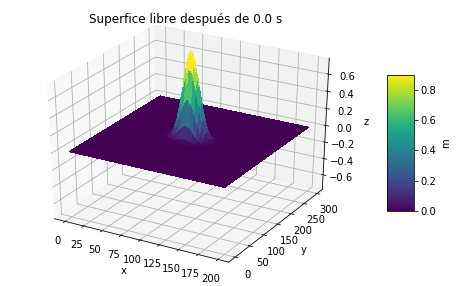

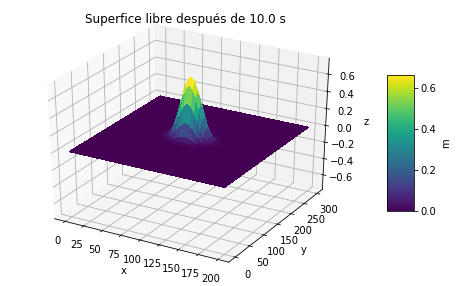

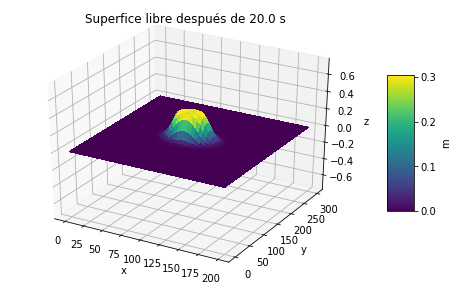

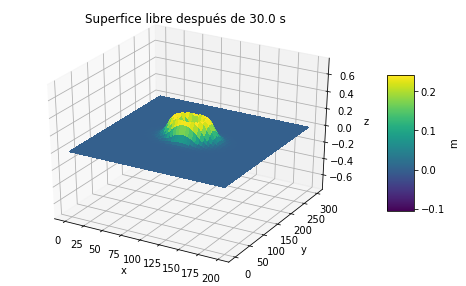

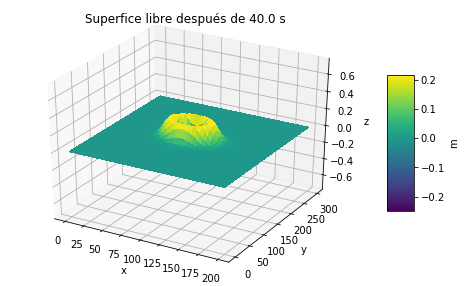

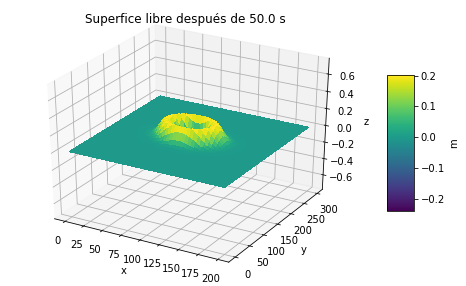

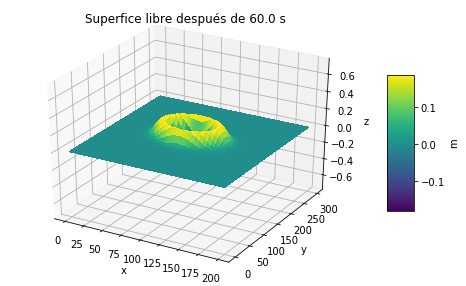

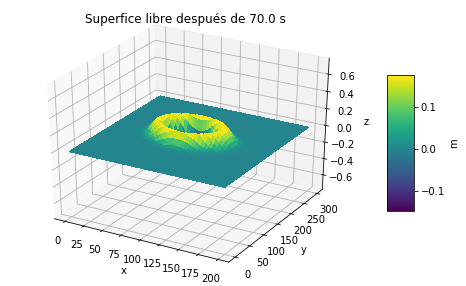

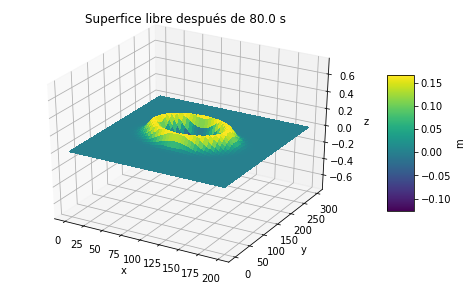

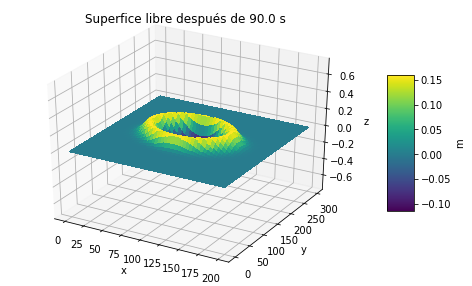

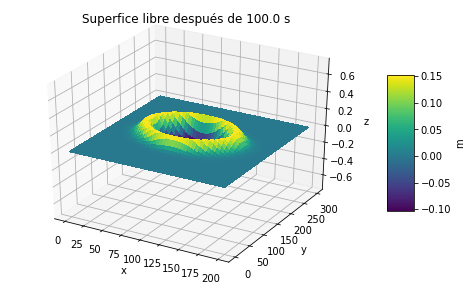

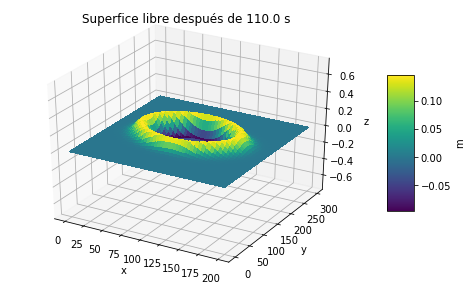

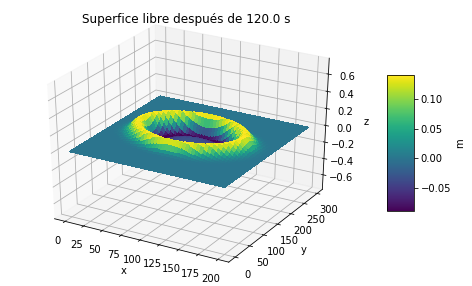

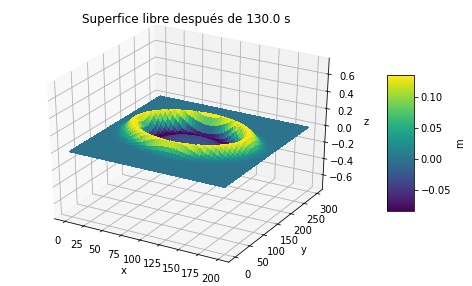

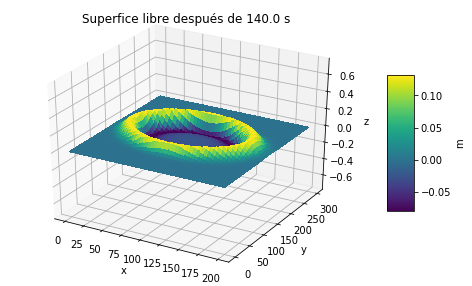

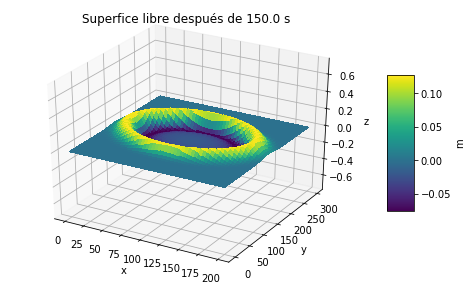

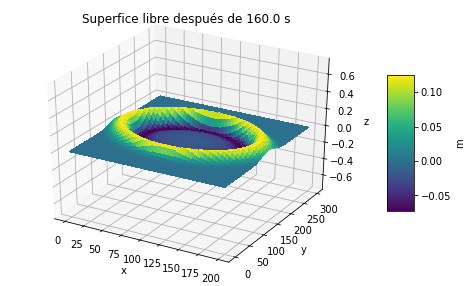

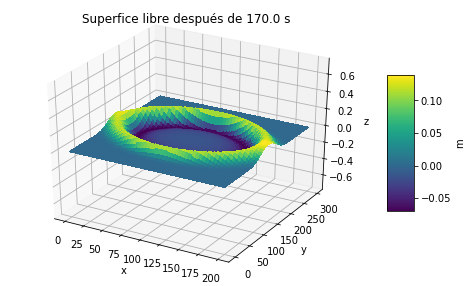

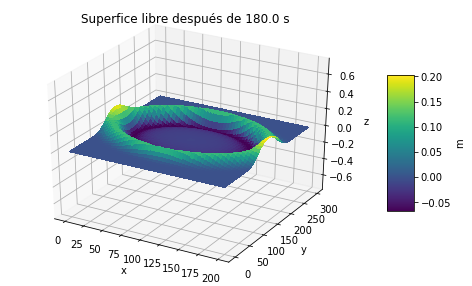

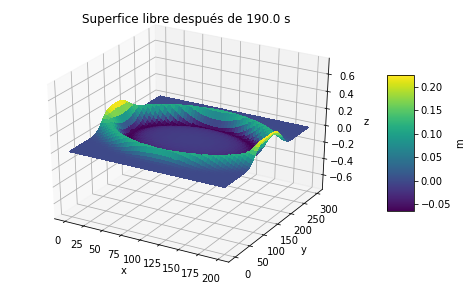

In [7]:
corre()

Y rápidamente podemos cambiar los parámetros de la corrida. Por ejemplo, hagamos una gausiana más ancha a lo largo de x cambiando el valor de s_x a 0.4:

la malla es de dimensiones:
(300, 200)
El paso de tiempo es 0.50
La resolución espacial es 100.00
El valor de CFL es 0.495227


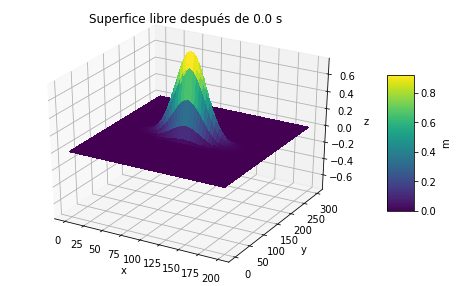

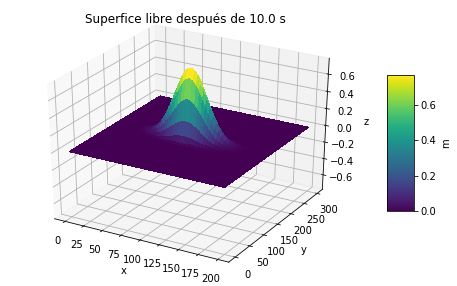

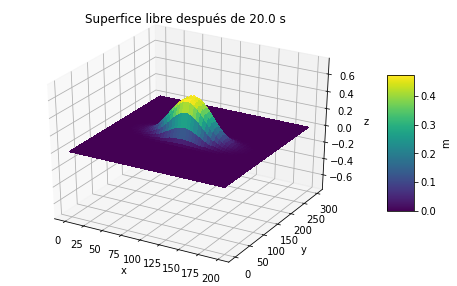

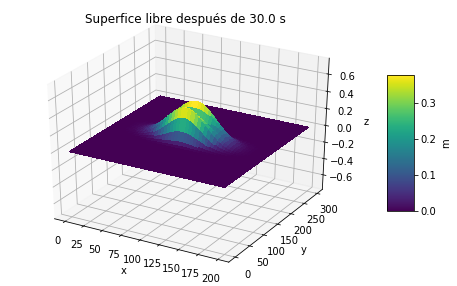

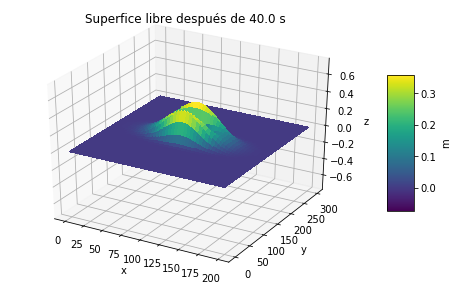

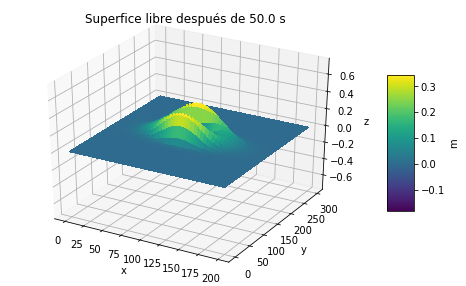

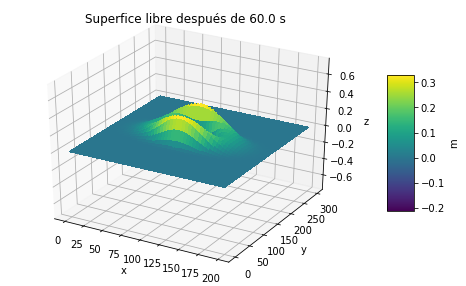

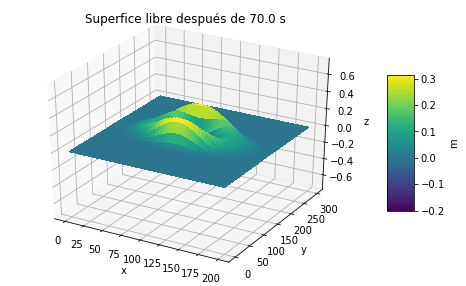

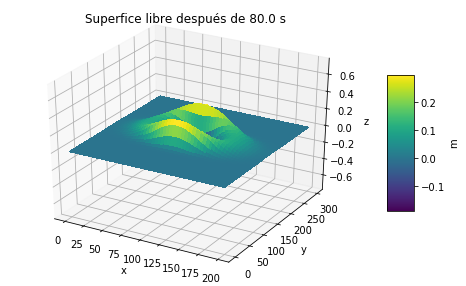

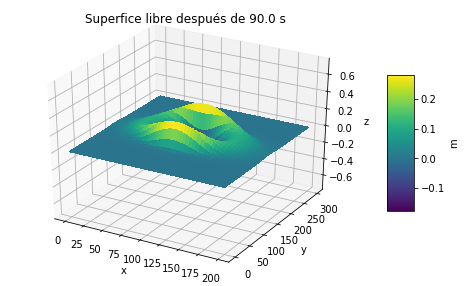

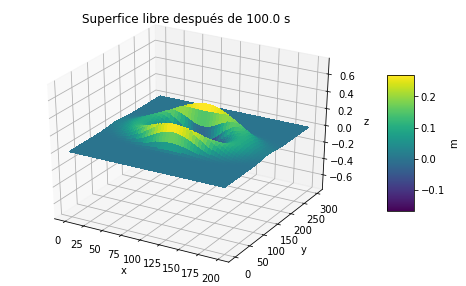

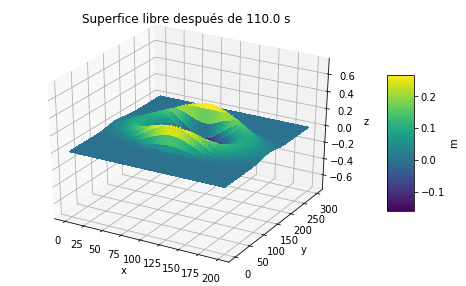

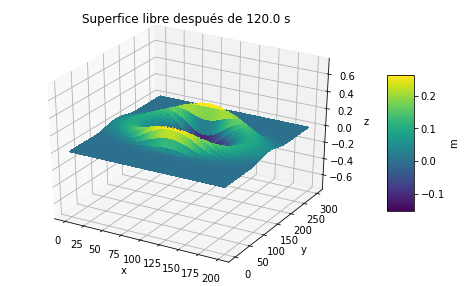

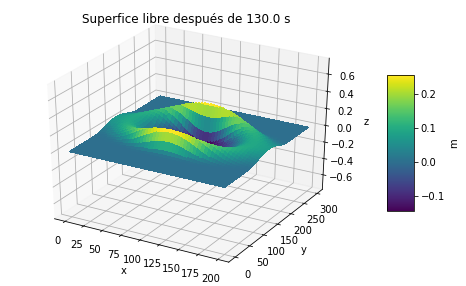

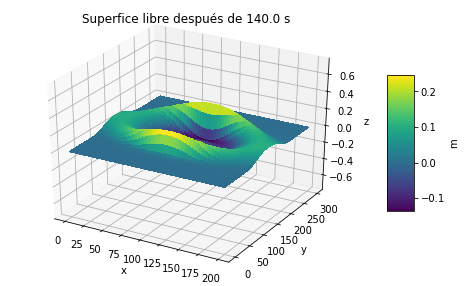

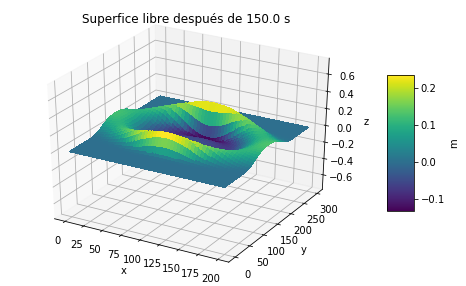

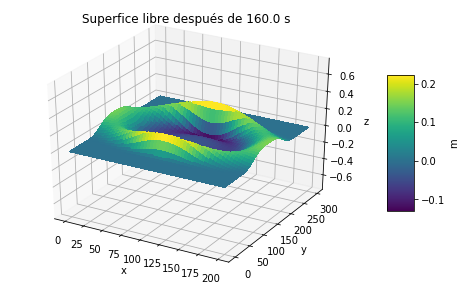

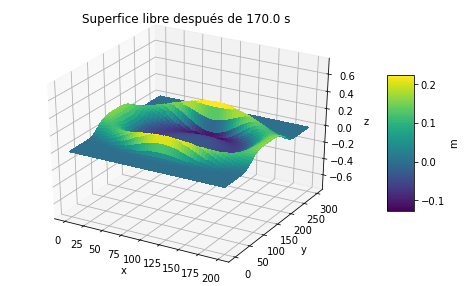

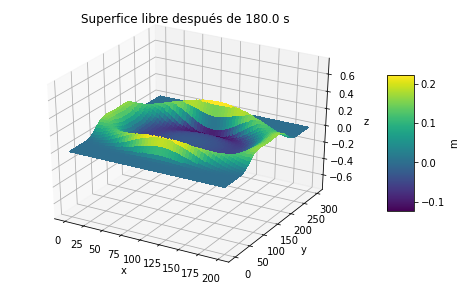

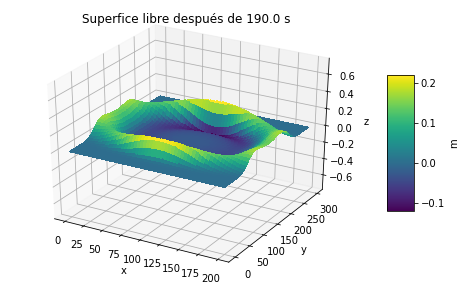

In [8]:
corre(s_x=0.4)

### Ejercicio:

Genera tu propia corrida cambiando los parámetros del modelo. Por ejemplo,integra por más pasos de tiempo, cambia la perturbación inicial y comenta cómo cambia la solución respecto a la configuración default.